# PCA in Tensorflow

In [1]:
import numpy as np
import tensorflow as tf
import tarfile
import io
import os
import psutil
import time
from tensorflow import keras
from google.cloud import storage
from tensorflow.keras.models import Model 
from keras import backend as K
from PIL import Image
from matplotlib import pylab as plt

print('Done: importing libraries')

Using TensorFlow backend.


Done: importing libraries


## Load preprocessed data

In [2]:
# preprocessed imgs are all 32x32
img_size = (32, 32)
pixels_per_img = np.prod(img_size)

# load training data
training_data_filename = 'train_img_array.pkl'
train_data_size = 1803460
full_train = np.memmap(training_data_filename, dtype='float32', mode='r+',
               shape=(train_data_size, img_size[0], img_size[1]))

print('Done: loading training data')

# load validation data
val_data_filename = 'val_img_array.pkl'
val_data_size = 36500
full_val = np.memmap(val_data_filename, dtype='float32', mode='r+',
               shape=(val_data_size, img_size[0], img_size[1]))

print('Done: loading validation data')

Done: loading training data
Done: loading validation data


In [ ]:
# check that it loaded properly
print('full train shape:', full_train.shape)
plt.imshow(full_train[4], cmap='Greys')
print('Done: test loading train data')

In [ ]:
# check that it loaded properly
print('full val shape:', full_val.shape)
plt.imshow(full_val[4], cmap='Greys')
print('Done: test loading val data')

train_data shape: (1803000, 32, 32)
train_data shape (flattened): (1803000, 1024)
val_data shape (flattened): (36500, 1024)
Done: test loading data (minus last 460 entries)


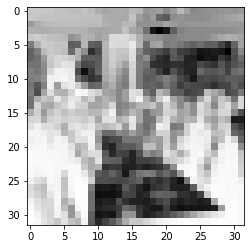

In [3]:
# not using full training dataset because last 460 entries were not preprocessed
train_data = full_train[:1803000]
print('train_data shape:', train_data.shape)
plt.imshow(train_data[100], cmap='Greys')

# flatten every image into a 1D vector to facilitate matrix computations later
train_data = train_data.flatten().reshape((len(train_data), pixels_per_img))
print('train_data shape (flattened):', train_data.shape)

# also flatten validation data
val_data = full_val.flatten().reshape((len(full_val), pixels_per_img))
print('val_data shape (flattened):', val_data.shape)

# convert to tensor (takes a few seconds)
# train_data_t = tf.convert_to_tensor(train_data, dtype = tf.float64)

print('Done: test loading data (minus last 460 entries)')

In [4]:
# small training data subset for debugging purposes
train_data_sub = tf.convert_to_tensor(train_data[:100], dtype=tf.float64)
val_data = tf.convert_to_tensor(val_data, dtype=tf.float64)

# val_data_sub = tf.convert_to_tensor(val_data[:100], dtype = tf.float64)

# print('train data shape:', train_data.shape)
# print('val data shape:', val_data.shape)

# setting up different-sized datasets so we can test how the PCA scales (takes a few secs each)
# note: I'm not going to assign them to variables here so we can save memory

# train_data_10k = tf.convert_to_tensor(train_data[:10000], dtype = tf.float64)
# train_data_50k = tf.convert_to_tensor(train_data[:50000], dtype = tf.float64)
# train_data_100k = tf.convert_to_tensor(train_data[:100000], dtype = tf.float64)
# train_data_200k = tf.convert_to_tensor(train_data[:200000], dtype = tf.float64)
# train_data_500k = tf.convert_to_tensor(train_data[:500000], dtype = tf.float64)

print('Done: setting up data subsets')

Done: setting up data subsets


## Implement PCA

References:
* https://dev.to/mmithrakumar/principal-components-analysis-with-tensorflow-2-0-21hl
* https://towardsdatascience.com/principal-component-analysis-in-depth-understanding-through-image-visualization-892922f77d9f

In [5]:
def normalize(data):
    """ Normalize the data 
    Args:
        data (tf.tensor)
    Returns:    
        norm_data (tf.tensor): normalized data
    """
    
    norm_data = tf.identity(data)
    norm_data -= tf.reduce_mean(norm_data, axis=0)
    return norm_data

print('Done: define normalize()')

Done: define normalize()


In [ ]:
# Tests ---

normalized_data = normalize(train_data_sub)

print('normalized data shape:', normalized_data.shape)

# display samples in first 2 dimensions
plt.plot(normalized_data[:,0], normalized_data[:,1], '+', color='b')
plt.grid()

print('Done: test normalized data')

In [6]:
def covariance_matrix(data):
    """ Compute covariance matrix of data 
    Args:
        data (tf.tensor)
    Returns:
        covmat (tf.tensor): covariance matrix of data
    """
    covmat = tf.tensordot(tf.transpose(data), data, axes=1)
    return covmat

In [ ]:
# Tests ---

print('test covariance matrix shape:', covariance_matrix(normalized_data).shape)

In [7]:
def pca(data):
    """ Perform PCA on the data to find principal components
    Args:
        data (tf.tensor): the data to find the principal components of
    Returns:
        eigen_values (tf.tensor), eigen_vectors (tf.tensor): the principal components
    """
    
    # normalize data
    norm_data = normalize(data)
    
    # compute covariance matrix
    covmat = covariance_matrix(norm_data)
    
    # compute eigenvalues & eigenvectors
    eigvals, eigvecs = tf.linalg.eigh(covmat)
    
    # Sort the eigenvectors based on their eigenvalues; from highest to lowest
    # inds = tf.argsort(eigvals, axis=-1, direction='DESCENDING')

    # Find the top `k` principal components and all eigenvalues
    # components = eigvecs[:,inds[:k]]  # how to do this with tensors???
    # eigenvalues = eigvals[inds]
    
    return eigvals, eigvecs


def pca_projection(eigvecs, data):
    """ Compute projection of data using principal components 
    Args:
        eigvecs: the principal components to project
    
    """
    proj = tf.tensordot(tf.transpose(eigvecs), tf.transpose(data), axes=1)

    return proj
    
print('Done: define pca() and pca_projection()')

Done: define pca() and pca_projection()


In [8]:
def reconstruction_error(original, proj):
    """ Compute the reconstruction error between the original data and the projection 
    Args:
        original: the original dataset
        proj: the pca projection of the data
    Returns: scalar representing RMSE of the original vs projection
    """
    return tf.reduce_mean((original - proj)**2)

print('Done: define reconstruction_error()')

Done: define reconstruction_error()


In [ ]:
# Tests ---

# garbage collection to free up memory
normalized_data = None

eigen_values, eigen_vectors = pca(train_data_sub)
projection = pca_projection(eigen_vectors, val_data)

print('eigen_values shape:', eigen_values.shape)
print('eigen_vectors shape:', eigen_vectors.shape)
print('projection shape:', projection.shape)
    
print('Done: project data using principle components')

In [ ]:
# display projection (in 2D for this example)
plt.plot(projection[0,:], projection[1,:], '+', color='b')
plt.grid()

# garbage collection
train_data_sub = None
projection = None
eigen_values = None
eigen_vectors = None

## Test PCA on various data subsets

Get the runtime, memory usage, and reconstruction (projection) error for each of the following dataset sizes:
1. 10000
2. 50000
3. 100000
4. 200000
5. 500000

In [11]:
def pca_test(data, validation):
    """ Run PCA and record metrics 
    
    Returns the eigen_values, eigen_vectors, projection
    """
    
    # runtime: start time
    start_time = time.time()
    # memory usage: memory in use before running pca
    pid = os.getpid()
    ps = psutil.Process(pid)
    before_memory = ps.memory_info()

    eigen_values, eigen_vectors = pca(data)
    projection = pca_projection(eigen_vectors, validation)
#     projection = pca_projection(eigen_vectors, data)
    
#     recon_err = reconstruction_error(data, tf.transpose(projection))
    recon_err = reconstruction_error(validation, tf.transpose(projection))
    
    # runtime: end time
    end_time = time.time()
    pca_time = end_time - start_time
    # memory usage: memory used after running pca
    after_memory = ps.memory_info()
    
    # print metrics
    print('METRICS for %d subset:' %(len(data)))
    print('pca runtime:', pca_time)
    print(f'rss: {after_memory.rss - before_memory.rss} bytes')
    print(f'vms: {after_memory.vms - before_memory.vms} bytes')
    
    print('reconstruction error:', recon_err)
    
    # display projection (in 2D for this example)
    plt.plot(projection[0,:], projection[1,:], '+', color='b')
    plt.grid()
    
    return eigen_values, eigen_vectors, projection
    

print('Done: define pca_test()')

Done: define pca_test()


In [ ]:
# test 10k
pca_test(tf.convert_to_tensor(train_data[:10000], dtype = tf.float64), val_data)
print('Done: test pca on 10k data subset')

In [ ]:
# test 50k
pca_test(tf.convert_to_tensor(train_data[:50000], dtype = tf.float64), val_data)
print('Done: test pca on 50k data subset')

In [ ]:
# test 100k
pca_test(tf.convert_to_tensor(train_data[:100000], dtype = tf.float64), val_data)
print('Done: test pca on 100k data subset')

In [ ]:
# test 200k
pca_test(tf.convert_to_tensor(train_data[:200000], dtype = tf.float64), val_data)
print('Done: test pca on 200k data subset')

In [12]:
# test 500k
eigen_values, eigen_vectors, projection = pca_test(tf.convert_to_tensor(train_data[:500000], dtype = tf.float64), val_data)
print('Done: test pca on 500k data subset')

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run Identity: Dst tensor is not initialized. [Op:Identity]

## Save Projection Output

Use np.memmap to store the projected validation data to the GCS bucket

In [ ]:
# store the validation data projection & principal components
output_projection = np.memmap('pca_output.pkl', dtype='float32', mode='w+', shape=(36500, 128))
output_projection = projection

print('Done: storing to pkl')